<a href="https://colab.research.google.com/github/Oliffka/lstm_classical_music_generator/blob/main/python/LSTM_music_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
Import required libraries
"""

!pip install np_utils

from keras.utils import to_categorical
import glob
import json
import numpy as np
import pickle
from matplotlib import pyplot as plt
from music21 import converter, instrument, note, chord, stream
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.callbacks import ModelCheckpoint

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56439 sha256=12eda768a30d23f727e9a3ca9f41079273120f8c69597da6b6c6e288fb3e98cc
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

#correct the paths to your datasets if needed
#the structure of the folders is: midi_datasets/mozart_midi/test/*.mid  <- these midi used as initial patterns while generating new music
#                                 midi_datasets/mozart_midi/train/*.mid <- these midi used for training
mozart_path = "/content/drive/My Drive/midi_datasets/mozart_midi/"
chopin_path = "/content/drive/My Drive/midi_datasets/chopin_midi/"
bach_path = "/content/drive/My Drive/midi_datasets/bach_midi/"

midi_path = chopin_path
midi_path_train = midi_path + "train/*"
midi_path_test = midi_path + "test/*"

#path where to save the models as ".h5" files
model_path = "/content/drive/My Drive/ai_models/"

#path for some temporary data
tmp_path = "/content/drive/My Drive/tmp/"

midiPath = tmp_path + 'test_midi.mid'
notesJsonPath = tmp_path + 'notes.json'

Mounted at /content/drive/


In [11]:
def train_network(inputLength, needToCreateModel, model = None):
    """
    Train a NN model for generation a new melody

    Arguments:
      inputLength: context length of the LSTM model
      needToCreateModel: indicates if model should be created
      model: if needToCreateModel is false, you have to pass already pre-trained
             model as an argument
    """

    # Parse songs from 'train' folder
    train_notes, train_songs = get_notes(midi_path_train)
    # Parse songs from 'test' folder
    test_notes, test_songs = get_notes(midi_path_test)

    print(train_songs)

    # Vocabulary must contain all possible notes/chords from both, train and test,
    # folders
    notes = train_notes + test_notes

    # Create vocabulary as a dictionary with all notes/chords from the dataset
    vocab, vocab_reverse = initVocabulary(notes)

    # Get vocabulary's size
    vocabSize = len(vocab)

    # Prepare data to feed the LSTM model:
    # <sequence of notes> -> note
    nn_input, nn_output = prepare_data(train_songs, vocab, inputLength)

    print("network input:")
    print(nn_input.shape)

    print("network output:")
    print(nn_output.shape)

    # Create model if needed
    if needToCreateModel:
      model = create_network(nn_input.shape, vocabSize)

    # Train the model with prepared input and output data
    history = train(model, nn_input, nn_output)

    return model, vocab, vocab_reverse, history

def get_notes(path):
  """
  Parse each midi file from the given folder to extract all the notes and chords

  Arguments:
    path: path to the folder with midi files
  Return:
    notes: 1d array, array of all notes/chords
    notes_by_song: 2d array, includes array of notes/chords of each song
  """
  notes = []
  notes_by_song = []

  for file in glob.glob(path):
    midi = converter.parse(file)

    print("Parsing current midi: %s" % file)

    notes_to_parse = None
    current_notes = [] # this array includes all notes/chords for the current song

    try: # midi file has several midi tracks by instrument
        s2 = instrument.partitionByInstrument(midi)
        for p in s2.parts:
            if 'piano' in p.instrumentName.lower(): # looking for a 'piano' midi instrument
                notes_to_parse = p.recurse()
                if len(notes_to_parse) >= input_length: # found midi track which has required number of notes
                    break
                else:
                    notes_to_parse = None #not found, looking for another one
    except: # file has notes in a flat structure
        notes_to_parse = midi.flatten().notes

    for element in notes_to_parse:
        if isinstance(element, note.Note):# if current element is single note
            note_str = str(element.pitch.midi)
            notes.append(note_str)
            current_notes.append(note_str)
        elif isinstance(element, chord.Chord):# if current element is chord
            pitches = [p.midi for p in element.pitches]
            pitches.sort() # sort pitches in ascending order
            if len(pitches) > 1: # sometimes chords have just 1 note, so no need to put '.'
              # chord string looks like '1.2.3', where 1,2,3 - midi notes (0-127)
              chord_str = '.'.join(str(p) for p in pitches)
              notes.append(chord_str)
              current_notes.append(chord_str)
            elif len(pitches) == 1:
              notes.append(pitches[0])
              current_notes.append(pitches[0])

    if len(current_notes) > 0: # if current song isn't empty, add it to the array of notes within the songs
      notes_by_song.append(current_notes)

  with open(notesJsonPath, 'w') as f:
    json.dump(notes, f)

  return (notes, notes_by_song)

def prepare_data(train_songs, vocab, input_length):
  """
  Prepare the data used by the Neural Network

  Arguments:
    train_songs: 2d array of notes within the song
    vocab: vocabulary, contains all possible notes/chords from the given dataset
    input_length: length of the context in notes
  Return:
    nn_input: network input, sequences of notes which form the context
    nn_output: network output, next note/chord following the given context
  """

  vocab_size = len(vocab)

  nn_input = []
  nn_output = []

  # create input sequences and the corresponding outputs
  for notes in train_songs:

    if (len(notes) < input_length):
      print("not enough notes in this song, song will be skipped, required length is ", input_length)
      continue
    for i in range(0, len(notes) - input_length, 1):
        sequence_in = notes[i:i + input_length]
        sequence_out = notes[i + input_length]

        nn_input.append([vocab[note] for note in sequence_in])
        nn_output.append(vocab[sequence_out])

  n_patterns = len(nn_input)

  # reshape the input into a format compatible with LSTM layers
  nn_input = np.reshape(nn_input, (n_patterns, input_length, 1))

  # normalize input
  nn_input = nn_input / float(vocab_size)

  nn_output = to_categorical(nn_output)

  return (nn_input, nn_output)

def create_network(nn_input_shape, vocabSize):
  """
  Create NN as a sequential model with 3 LSTM layers,
  the last Dense level has vocabulary size

  Arguments:
    nn_input_shape: input shape of the trainig data
    vocabSize: size of the vocabulary
  Return:
    model: NN model with the required structure
  """

  model = Sequential()
  model.add(LSTM(
      512,
      input_shape=(nn_input_shape[1], nn_input_shape[2]),
      recurrent_dropout=0.3,
      return_sequences=True
  ))
  model.add(LSTM(512, return_sequences=True, recurrent_dropout=0.3,))
  model.add(LSTM(512))
  model.add(BatchNorm())
  model.add(Dropout(0.3))
  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(BatchNorm())
  model.add(Dropout(0.3))
  model.add(Dense(vocabSize))
  model.add(Activation('softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics = "accuracy")

  return model

def train(model, nn_input, nn_output):
  """
  Train the neural network

  Arguments:
    model: model to train
    nn_input: input sequences of notes
    nn_ouput: output notes
  Return:
    history: history of the trainig, can be used later to draw the plots
  """
  filepath = model_path + "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
  checkpoint = ModelCheckpoint(
      filepath,
      monitor='loss',
      verbose=0,
      save_best_only=True,
      period=20, # save intermediate results as '.hdf5' file every 20 epochs
      mode='min'
  )
  callbacks_list = [checkpoint]

  history = model.fit(nn_input, nn_output, epochs=150, batch_size=128, verbose=1,
                      callbacks=callbacks_list)

  return history

def save_model(model, modelName):
  """
  Save NN model on the gDrive as ".h5" file, including weights and architecture

  Arguments:
    model: pre-trained model
    modelName: name of the model, to be used building the path
  Return:
    history: history of the trainig, can be used later to draw the plots
  """

  modelPath = model_path + modelName + '.h5' #model path must contain '/' at the end
  model.save(modelPath, overwrite=True)
  print('Model successfully saved: ', modelPath)

def saveVocabulary(vocab, name):
  """
  Save vocabulary on the gDrive as ".json" file

  Arguments:
    vocab: vocabulary, which is a dictionary "chord": "index"
    name: name of the vocabulary, to be used building the path
  """

  vocabPath = model_path + name + '.json'
  with open(vocabPath, 'w') as f:
    json.dump(vocab, f)

def initVocabulary(notes):
  """
  Create a dictionary to map notes/chords to integers

  Arguments:
    notes: sequence of notes/chords from all the songs within the given dataset

  Return:
    vocab: dictionary, "chord_string" : "index"
    vocab_reverse: dictionary, "index" : "chord_string"
  """

  uniqueItems = notes
  uniqueItems = sorted(set(item for item in notes)) # get sorted unique notes/chords

  # building vocabulary
  vocab = dict((note, number) for number, note in enumerate(uniqueItems))
  vocab_reverse = dict((number, note) for number, note in enumerate(uniqueItems))

  print("Vocabulary initialized successfully")
  print("Vocab_size = ", len(vocab))
  return vocab, vocab_reverse

In [9]:
def generate(model, vocab, vocab_reverse, input_length):
  """
  Generate a new midi sequence using given pretrained model

  Arguments:
    model: pre-trained model which predicts the next note based on the context
    vocab: vocabulary which contains all possible notes/chords for given musical style
    vocab_reverse: same vocabulary with reversed <key, value> pairs
    input_length: length of the context
  """
  vocabSize = len(vocab)

  # parse test dataset
  test_notes, song_notes = get_notes(midi_path_test)

  # choose senquence of input_length notes starting from random index
  start = np.random.randint(0, len(test_notes)- input_length)
  random_seq = test_notes[start:start+input_length]

  print("random_seq: ", random_seq)

  # form nn_input in proper way
  nn_input = []
  nn_input.append([vocab[note] for note in random_seq])
  nn_input = nn_input[0]

  print("network_input len: ", len(nn_input))

  # get sequence of predicted notes based on input sequence <nn_input>
  prediction_output = generate_notes(model, nn_input, vocab_reverse)

  # crete midi file and save it to gDrive
  create_midi(prediction_output)

def generate_notes(model, init_pattern, vocab):
  """
  Generate notes via NN model from the given initial pattern

  Arguments:
    model: pre-trained nn model
    init_pattern: initial pattern for nn input
    vocab: vocabulary

  Return:
    prediction_output: predicted sequence of notes based on initial_pattern
  """

  print("initpattern len: ", len(init_pattern))
  pattern = init_pattern
  prediction_output = []

  vocabSize = len(vocab)

  # generate 100 notes (just for example)
  for note_index in range(100):
      #reshape input data to be suitable for LSTM model
      prediction_input = np.reshape(pattern, (1, len(pattern), 1))
      #normalize input according to vocabulary size
      prediction_input = prediction_input / float(vocabSize)

      # get predictions across all items in vocabulary
      prediction = model.predict(prediction_input, verbose=0)

      # find element with max probability to happen
      index = np.argmax(prediction)
      result = vocab[index]

      # add predicted note/chord to the output sequence
      prediction_output.append(result)

      # shift input sequence by 1 note to generate next note
      pattern.append(index)
      pattern = pattern[1:len(pattern)]

  return prediction_output

def create_midi(prediction_output):
  """
  Create midi file from predicted notes/chordes

  Arguments:
    prediction_output: predicted sequence of notes/chords
  """

  offset = 0
  output_notes = []

  # create note or chord objects based on predicted_output
  for pattern in prediction_output:
      # pattern is a chord
      if ('.' in pattern):
          notes_in_chord = pattern.split('.')
          notes = []
          for current_note in notes_in_chord:
              new_note = note.Note(int(current_note))
              # we want to create piano midi track
              new_note.storedInstrument = instrument.Piano()
              notes.append(new_note)
          # create chord from notes
          new_chord = chord.Chord(notes)
          # we assume notes have the same duration and same onset-intervals b/n notes
          new_chord.offset = offset
          output_notes.append(new_chord)
      # pattern is a note
      else:
          new_note = note.Note(int(pattern))
          new_note.offset = offset
          new_note.storedInstrument = instrument.Piano()
          output_notes.append(new_note)

      # increase offset each iteration so that notes do not stack
      offset += 0.5

  midi_stream = stream.Stream(output_notes)

  # save as file with the given path
  midi_stream.write('midi', fp=midiPath)
  print("midi file saved successfully: ", midiPath)

In [ ]:
"""
Examples of how I trained models in different styles with given input length
"""

# let's train model with Mozart dataset
midi_path = mozart_path
midi_path_train = midi_path + "train/*"
midi_path_test = midi_path + "test/*"

input_length = 100
name = "Mozart"

# sometimes the runtime diconnects during training so it was useful to save intermediate
# results and keep training starting from the saved weights, not from scratch
'''
from keras.models import load_model
path = model_path + "mozart_100.h5"
model = load_model(path)


model, vocab, vocab_reverse, history_mozart_100 = train_network(input_length, name, False, model)
'''

# if you want to train from scratch
model, vocab, vocab_reverse, history_mozart_100 = train_network(input_length, name, True)

# save model and vocabulary on gDrive
save_model(model, "mozart_100")
saveVocabulary(vocab, "mozart_100")

# saving history on gDrive if we want to use it later
history_path = tmp_path + 'history_mozart100'
with open(history_path, 'wb') as file_pi:
    pickle.dump(history_mozart_100.history, file_pi)


# now let's train model considering Chopin dataset
midi_path = chopin_path
midi_path_train = midi_path + "train/*"
midi_path_test = midi_path + "test/*"

input_length = 100
name = "Chopin"

'''
from keras.models import load_model
path = model_path + "chopin_100.h5"
model = load_model(path)

model, vocab, vocab_reverse, history_chopin_100 = train_network(input_length, name, False, model)
'''

model, vocab, vocab_reverse, history_chopin_100 = train_network(input_length, name, True)


save_model(model, "chopin_100")
saveVocabulary(vocab, "chopin_100")

history_path = tmp_path + 'history_chopin100'
with open(history_path, 'wb') as file_pi:
    pickle.dump(history_chopin_100.history, file_pi)


# now it's Bach's turn :)
midi_path = bach_path
midi_path_train = midi_path + "train/*"
midi_path_test = midi_path + "test/*"

input_length = 100
name = "Bach"

'''
from keras.models import load_model
path = model_path + "bach_100.h5"
model = load_model(path)

model, vocab, vocab_reverse, history_bach_100 = train_network(input_length, name, False, model)
'''

model, vocab, vocab_reverse, history_bach_100 = train_network(input_length, name, True)


save_model(model, "bach_100")
saveVocabulary(vocab, "bach_100")

history_path = tmp_path + 'history_bach100'
with open(history_path, 'wb') as file_pi:
    pickle.dump(history_bach_100.history, file_pi)


Model loss:


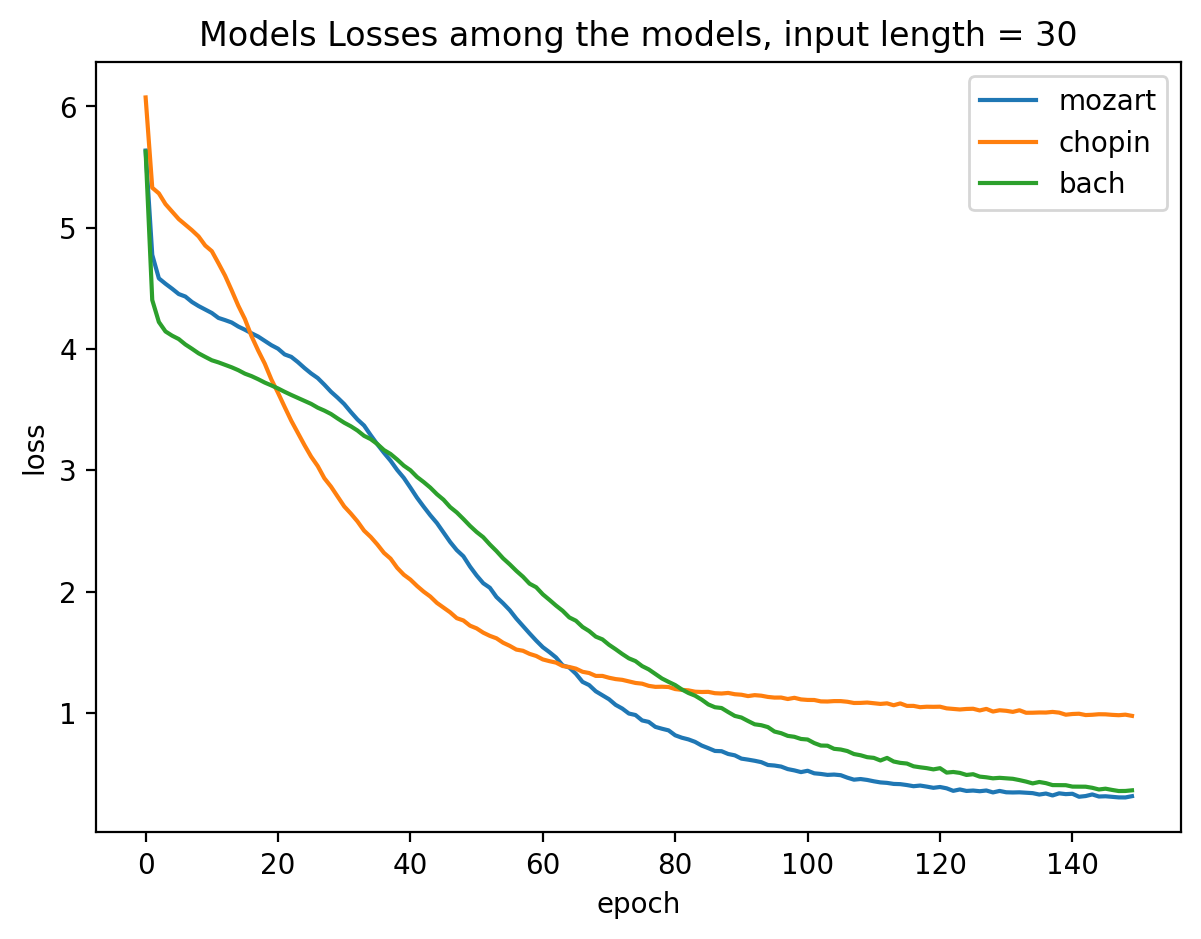

Model accuracy:


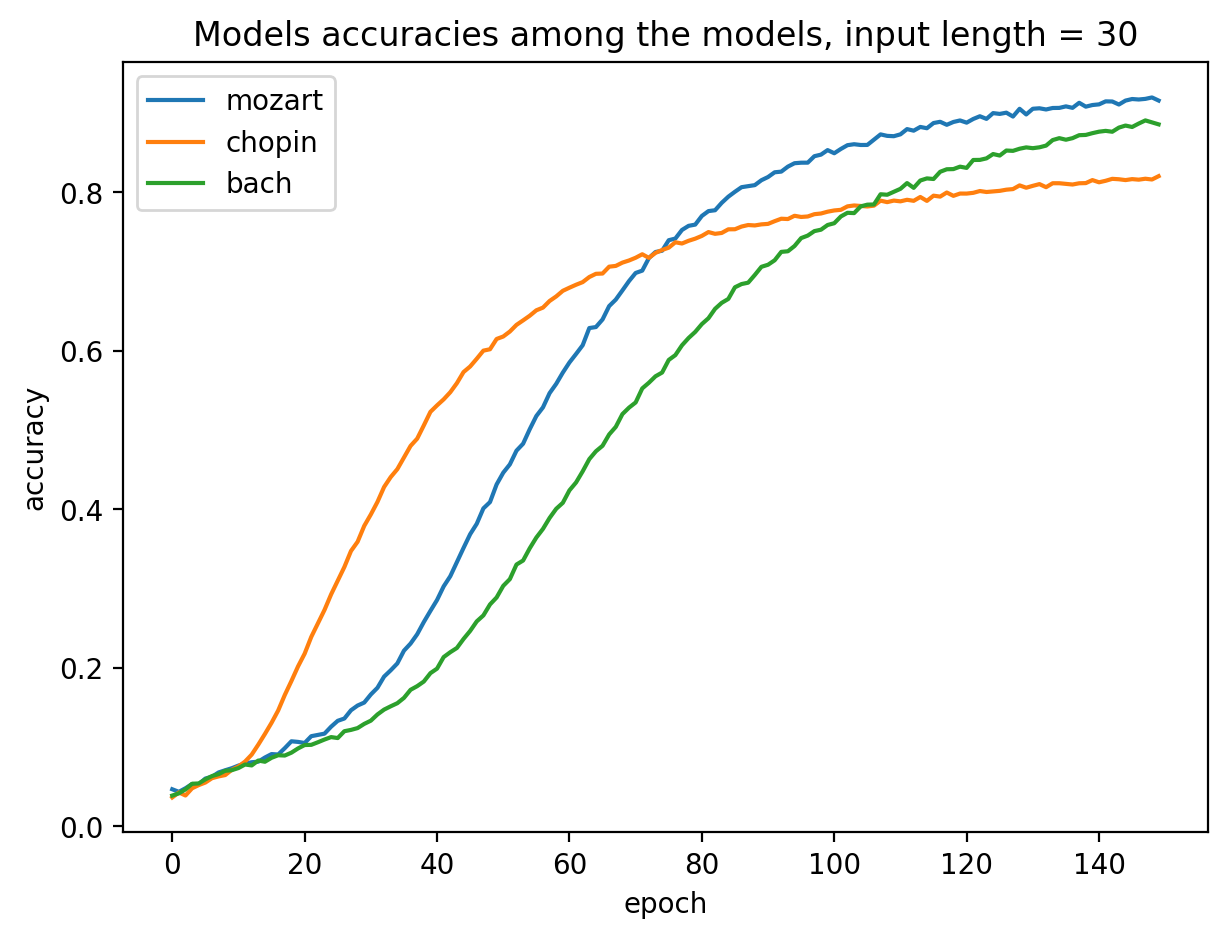

Model loss:


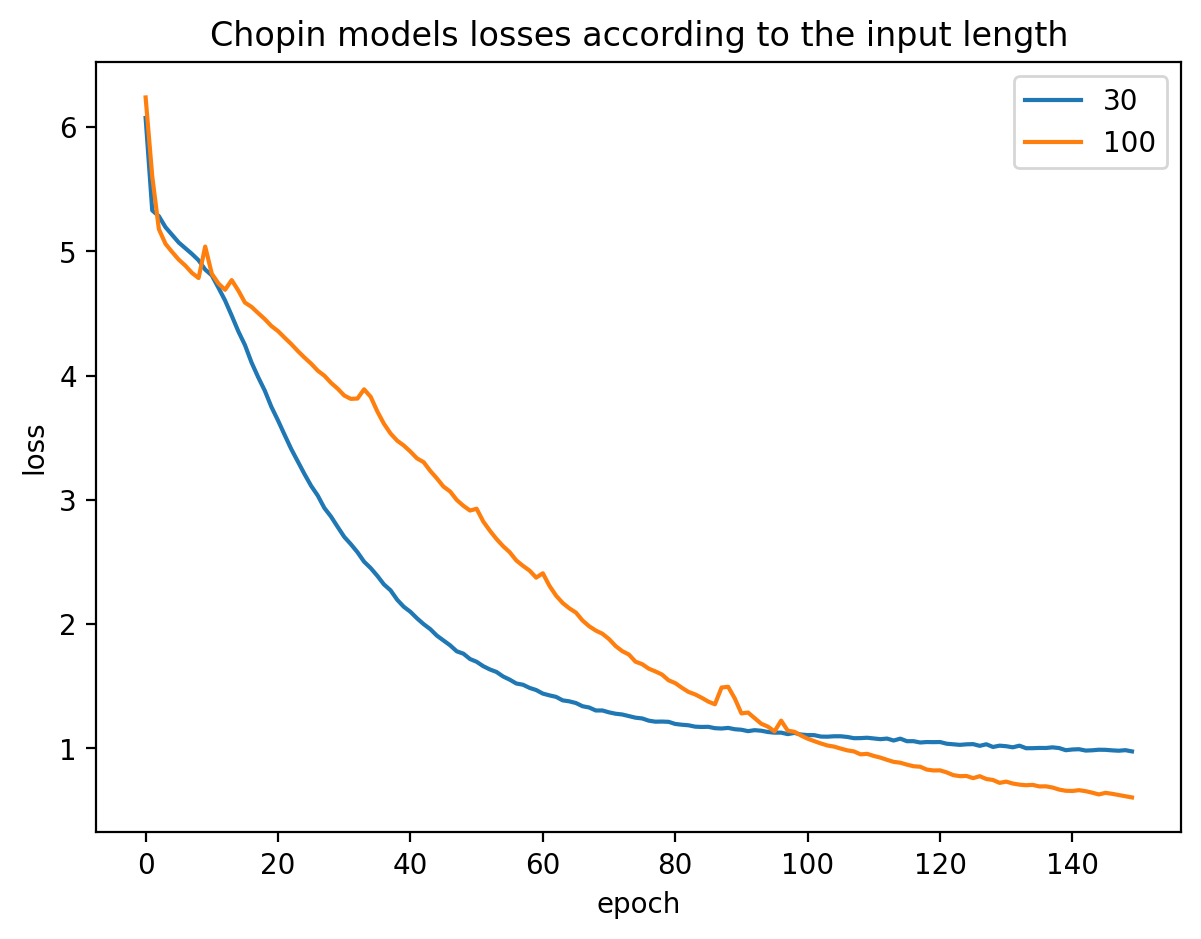

Model accuracy:


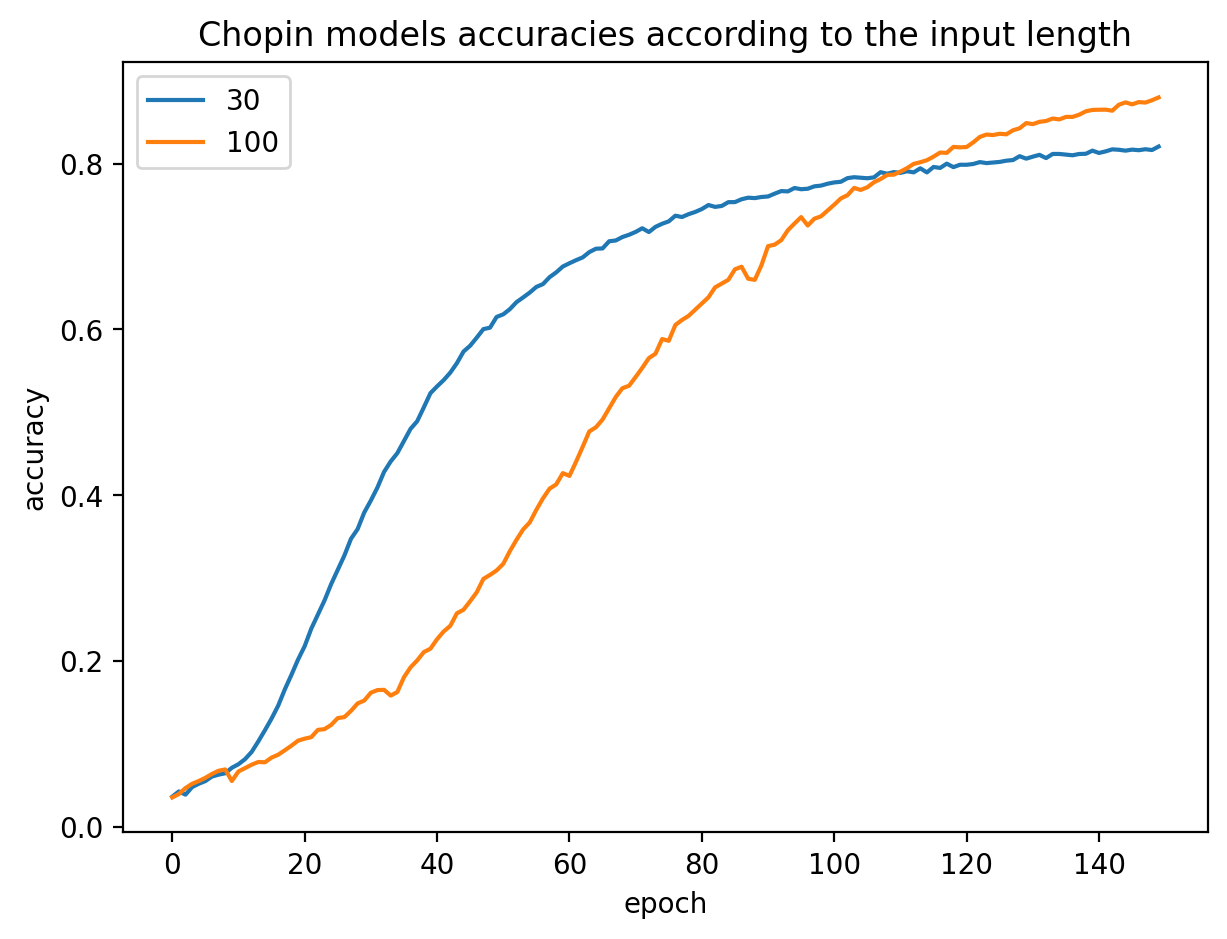

Model loss:


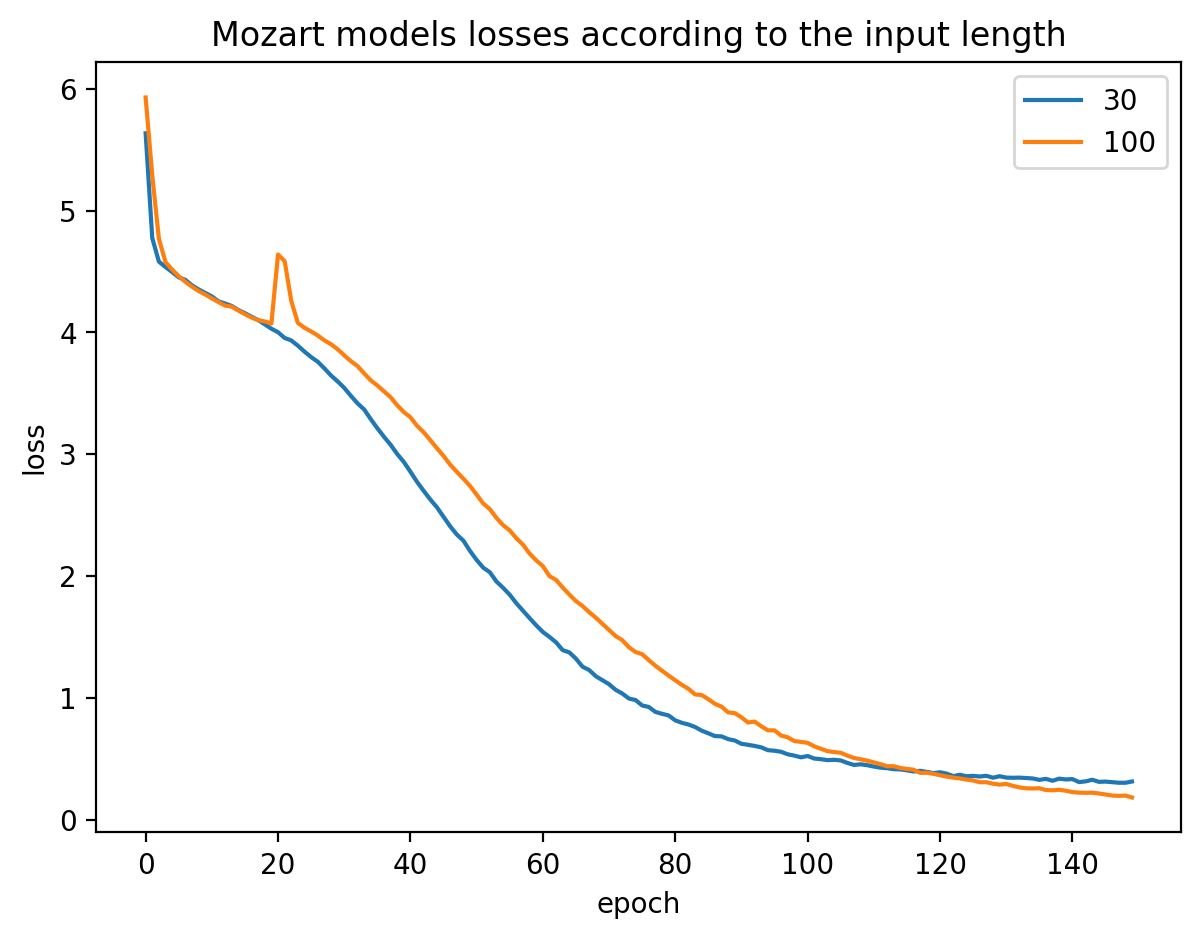

Model accuracy:


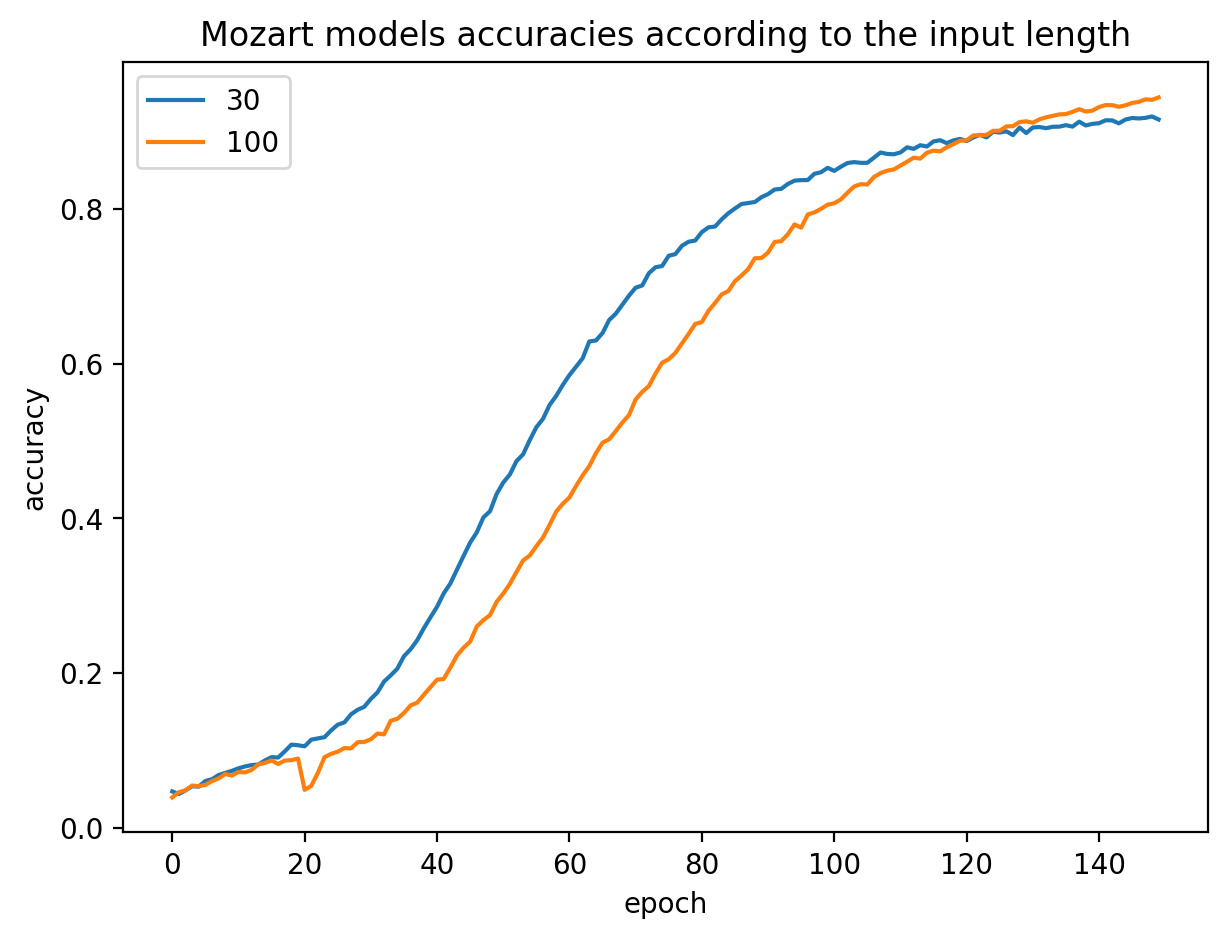

In [10]:
"""
Example of plotting graphs.
Here i assumed that the histories were saved after trainigs
"""

import pickle

path_mozart_30 = tmp_path + 'history_mozart_30'
with open(path_mozart_30, "rb") as file_pi:
  history_mozart_30 = pickle.load(file_pi)

path_mozart_100 = tmp_path + 'history_mozart_100'
with open(path_mozart_100, "rb") as file_pi:
  history_mozart_100 = pickle.load(file_pi)

path_chopin_30 = tmp_path + 'history_chopin_30'
with open(path_chopin_30, "rb") as file_pi:
  history_chopin_30 = pickle.load(file_pi)

path_chopin_100 = tmp_path + 'history_chopin_100'
with open(path_chopin_100, "rb") as file_pi:
  history_chopin_100 = pickle.load(file_pi)

path_bach_30 = tmp_path + 'history_bach_30'
with open(path_bach_30, "rb") as file_pi:
  history_bach_30 = pickle.load(file_pi)

print("Model loss:")
plt.figure(1, figsize=(7,5))
plt.plot(history_mozart_30['loss'], label='mozart')
plt.plot(history_chopin_30['loss'], label='chopin')
plt.plot(history_bach_30['loss'], label='bach')
plt.title('Models Losses among the models, input length = 30')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

print("Model accuracy:")
plt.figure(2, figsize=(7,5))
plt.plot(history_mozart_30['accuracy'], label='mozart')
plt.plot(history_chopin_30['accuracy'], label='chopin')
plt.plot(history_bach_30['accuracy'], label='bach')
plt.title('Models accuracies among the models, input length = 30')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

print("Model loss:")
plt.figure(1, figsize=(7,5))
plt.plot(history_chopin_30['loss'], label='30')
plt.plot(history_chopin_100['loss'], label='100')
plt.title('Chopin models losses according to the input length')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

print("Model accuracy:")
plt.figure(2, figsize=(7,5))
plt.plot(history_chopin_30['accuracy'], label='30')
plt.plot(history_chopin_100['accuracy'], label='100')
plt.title('Chopin models accuracies according to the input length')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()


print("Model loss:")
plt.figure(1, figsize=(7,5))
plt.plot(history_mozart_30['loss'], label='30')
plt.plot(history_mozart_100['loss'], label='100')
plt.title('Mozart models losses according to the input length')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

print("Model accuracy:")
plt.figure(2, figsize=(7,5))
plt.plot(history_mozart_30['accuracy'], label='30')
plt.plot(history_mozart_100['accuracy'], label='100')
plt.title('Mozart models accuracies according to the input length')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [10]:
"""
Example of visualizing model's architecture
Here i assumed that the model was saved as '.h5' file on gDrive and later loaded via load_model(path)
"""

from tensorflow.keras.utils import plot_model

from keras.models import load_model
path = model_path + "bach_100.h5"
model = load_model(path)

plot_model(model, show_shapes=True, show_layer_names=True)

"""
Example of generating a new mdelody and saving it as midi file on gDrive
"""

generate(model, vocab, vocab_reverse, input_length)

Parsing current midi: /content/drive/My Drive/midi_datasets/bach_midi/test/Loure 2.mid
Parsing current midi: /content/drive/My Drive/midi_datasets/bach_midi/test/Das Wohltemperierte Clavier I, Praeludium II.mid
Parsing current midi: /content/drive/My Drive/midi_datasets/bach_midi/test/BWV 1006a - Prélude.mid
Parsing current midi: /content/drive/My Drive/midi_datasets/bach_midi/test/Badinerie.mid
Parsing current midi: /content/drive/My Drive/midi_datasets/bach_midi/test/Air in D Major.mid
random_seq:  ['76', '75', '73', '71', '64', '73', '64', '71', '64', '69', '64', '68', '71', '66', '71', '68', '71', '69', '71', '68', '71', '66', '71', '64', '76', '75', '73', '71', '64', '73', '64', '71', '64', '69', '64', '68', '64', '64', '64', '63', '64', '64', '64', '66', '64', '63', '64', '64', '64', '68', '64', '66', '64', '68', '64', '69', '64', '66', '64', '68', '64', '64', '64', '63', '64', '64', '64', '66', '64', '63', '64', '64', '64', '68', '64', '66', '64', '68', '64', '69', '64', '66', 